In [1]:
#all the imports used in the program

import pandas as pd 
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from keras.layers import GlobalMaxPool1D, Conv1D, Dropout, GRU, Flatten, MaxPooling1D
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import sklearn.metrics as skm

Using TensorFlow backend.


In [2]:
#Grab data from a database

def getData(Server, UID, PWD, Database, query):    
    
    #create a SQL connection based on the given server and database
    sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                              'SERVER='+Server+';' 
                              'UID='+UID+';'
                              'PWD='+PWD+';'
                              'DATABASE='+Database+';' )
    
    #return the data from the given Query and SQL connection,
    return pd.read_sql(query, sql_conn)

In [3]:
#establish my server and corresponding database to pull data from
server ='GSDEMO2HOST'
database = 'MClinical'
UID = 'gsanalytics'
PWD = 'G3st@lt'


#Stores the result in a pandas DataFrame object called data
query ="SELECT ISNULL(ProcedureStep.subSpecialtyCd,'UNKNOWN') AS subSpecialtyCd, FillerOrder.fillerOrderStatusCd, PL.locationName, BUCKETS.BUCKETNUM FROM BUCKETS LEFT JOIN ProcedureStep ON BUCKETS.PSKEY = ProcedureSteP.procedureStepKey LEFT JOIN RequestedProcedure ON ProcedureStep.requestedProcedureKey = RequestedProcedure.requestedProcedureKey LEFT JOIN FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey"
original = getData(server, UID, PWD, database,query)
data = original.copy()


In [4]:
data = original.copy()

In [5]:
#concatinate the selected params
def concatParam(df):
    return  df['subSpecialtyCd'] + ' ' + df['fillerOrderStatusCd'] + ' ' + df['locationName']

In [6]:
def clean(df):
    #create a new column where its all the params concatinated by spaces
    df['concat'] = concatParam(df)
    
    #change the case of all the words to lower case so there is no case sensitivity.
    df['concat'] = df['concat'].str.lower()
    return df['concat']

In [7]:
data['concat'] = clean(data)
data.concat.apply(lambda x: len(x.split(" "))).mean()

5.0

In [8]:
def convert_text(df, maxlen, max_words):
    #split df into two series
    #texts being the concat
    #labels being the cooresponding bucket
    texts = df.concat
    labels = df.BUCKETNUM
    
    #convert the series into numpy arrays
    texts = texts.values
    temp_labels = labels.values
    
    #create a empty array for our labels that we will convert to integers
    labels = []
    
    #grab all the unique buckets (5) 
    #this will be our dictonary for mapping between integers and buckets
    label_dict = [1,2,3,4,5]
    label_dict = np.asarray(label_dict)

    
    for label_type in temp_labels:
        labels.append(np.searchsorted(label_dict, label_type))
    
    labels = np.asarray(labels)
    
    #create a tokenizer based on the max_words
    #fit the tokenizer to our specific texts
    #change our texts to a vetorized integer
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    #pad sequences ensures that all our vectors are of the same length
    x = pad_sequences(sequences, maxlen=maxlen)
    
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    x = x[indices]
    labels = labels[indices]

    print('Shape of data tensor:', x.shape)
    print('Shape of label tensor:', labels.shape)
    
    #return x, labels, and the last 7000 of x and labels for testing
    return x[:1000], labels[:1000], x[-9000:], labels[-9000:], indices

In [9]:
#define maxlen as the maximum words to take from each sectionValue
#define max_words as the total number of unique words to tokenize

maxlen = 8
max_words = 20

#create data that can be ran through our model
x_train, y_train, x_test, y_test, index = convert_text(data, maxlen, max_words)

data = data.reindex(index)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Found 20 unique tokens.
Shape of data tensor: (10000, 8)
Shape of label tensor: (10000,)
(1000, 8)
(1000,)
(9000, 8)
(9000,)


In [10]:
#create a machine learning model with the following
def create_model(max_words,maxlen):
    #keras default model
    model = Sequential()
    
    #add an embedding layer with the input dim and input length to what we have already
    #configured for our vectorized forms of our text
    model.add(Embedding(input_dim = max_words, input_length=maxlen, output_dim = 50))
    
    #model.add(Embedding(max_words,50, input_length=maxlen, embeddings_initializer="uniform"))
    
    #add a bidirectional LSTM layer with 32 units
    model.add(Bidirectional(LSTM(units =32)))
    
    #model.add(Conv1D(maxlen, 1, padding='valid', activation='relu', strides=1))
    #model.add(GlobalMaxPool1D())
    
    # create a dense output layer with the units = len(labels_dict)
    model.add(Dense(5, activation='softmax'))
    
    #print the summary
    model.summary()
    
    return model

In [11]:
#create the model
model = create_model(max_words, maxlen)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 50)             1000      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                21248     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 22,573
Trainable params: 22,573
Non-trainable params: 0
_________________________________________________________________


In [12]:
#train the model
def train_model(model, x_train, y_train, epochs, batchsize, max_words, max_len):
    #compile the model
    #optimizer -> rmsprop (standard)
    #loss -> sparse categorical crossentropy (because we have a large multiclassifcation probelm)
    #meteric -> accuracy
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc']) 
    #save the history from the model
    #set the paramiters
    #fit the model 
    history = model.fit(x_train, 
                        y_train,
                        epochs=epochs,
                        batch_size=batchsize,
                        validation_split=0.75)
    return history

In [13]:
#train the model
history = train_model(model, x_train, y_train, 120, 80, max_words, maxlen)

Instructions for updating:
Use tf.cast instead.
Train on 250 samples, validate on 750 samples
Epoch 1/120
250/250 [==============================] - 2s 9ms/step - loss: 1.5970 - acc: 0.2920 - val_loss: 1.5749 - val_acc: 0.3107
Epoch 2/120
250/250 [==============================] - 0s 267us/step - loss: 1.5681 - acc: 0.3200 - val_loss: 1.5487 - val_acc: 0.3107
Epoch 3/120
250/250 [==============================] - 0s 267us/step - loss: 1.5408 - acc: 0.3200 - val_loss: 1.5157 - val_acc: 0.3107
Epoch 4/120
250/250 [==============================] - 0s 270us/step - loss: 1.5070 - acc: 0.3200 - val_loss: 1.4839 - val_acc: 0.3107
Epoch 5/120
250/250 [==============================] - 0s 259us/step - loss: 1.4745 - acc: 0.3200 - val_loss: 1.4481 - val_acc: 0.3107
Epoch 6/120
250/250 [==============================] - 0s 285us/step - loss: 1.4360 - acc: 0.3200 - val_loss: 1.4089 - val_acc: 0.3107
Epoch 7/120
250/250 [==============================] - 0s 315us/step - loss: 1.3963 - acc: 0.3200 

250/250 [==============================] - 0s 327us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.1021 - val_acc: 0.9893
Epoch 60/120
250/250 [==============================] - 0s 287us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.1009 - val_acc: 0.9893
Epoch 61/120
250/250 [==============================] - 0s 255us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.1016 - val_acc: 0.9893
Epoch 62/120
250/250 [==============================] - 0s 263us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.1017 - val_acc: 0.9893
Epoch 63/120
250/250 [==============================] - 0s 286us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.1019 - val_acc: 0.9893
Epoch 64/120
250/250 [==============================] - 0s 267us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.1033 - val_acc: 0.9893
Epoch 65/120
250/250 [==============================] - 0s 271us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.1033 - val_acc: 0.9893
Epoch 66/120
250/250 [==============================] - 0s 26

Epoch 118/120
250/250 [==============================] - 0s 299us/step - loss: 1.4162e-05 - acc: 1.0000 - val_loss: 0.1322 - val_acc: 0.9893
Epoch 119/120
250/250 [==============================] - 0s 267us/step - loss: 1.3028e-05 - acc: 1.0000 - val_loss: 0.1295 - val_acc: 0.9893
Epoch 120/120
250/250 [==============================] - 0s 263us/step - loss: 1.2402e-05 - acc: 1.0000 - val_loss: 0.1324 - val_acc: 0.9893


In [14]:
#generate the report for the training process
def training_report(history):
    #get the data from the model history file 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #set our epochs
    epochs = range(1, len(acc) + 1)

    #plot the accuracy 
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    
    #plot the loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    #display the max values we attained
    print('Validation Accuracy: ', val_acc[np.argmax(val_acc)] * 100)
    print('Training Accuracy: ', acc[np.argmax(acc)] * 100)

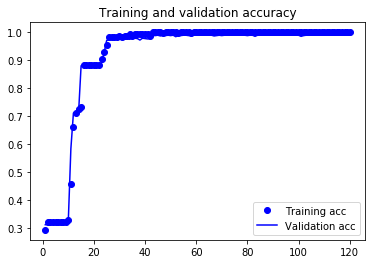

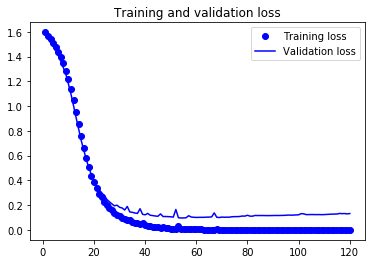

Validation Accuracy:  98.93333371480307
Training Accuracy:  100.0


In [15]:
training_report(history)

In [16]:
#test the model on our set aside testing data
def test_model(model, x_test):
    #gather the models prediction 
    
    #the model displays its prediction as a percent for every bucket at how confident the model is for 
    #each bucket. 
    
    #the highest percent in our case the the bucket the model has choosen
    preds = model.predict(x_test)
    
    y_pred = []
    
    #for ever row in the prediction list
    #grab the max value and append that index to the y_pred
    for row in preds:
        y_pred.append(np.argmax(row))
    
    #convert the list to a numpy array
    return np.asarray(y_pred)

In [17]:
#test the model against our test data and store the predictions in y_pred
y_pred = test_model(model, x_test)

In [18]:
#create the confusion matrix
def test_confusion_matrix(y_pred,y_test):
    print(confusion_matrix(y_test, y_pred))

In [19]:
#create the classification report
def test_classification_report(y_pred,y_test):
    print(skm.classification_report(y_test, y_pred))

In [20]:
test_confusion_matrix(y_pred,y_test)

[[2752    0    0    0    0]
 [   0 1483    0    0    2]
 [   0    0 2409    0    0]
 [   0    4    0 1517    0]
 [   0   76    0    0  757]]


In [21]:
#display the classification report on the predictions
test_classification_report(y_pred, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2752
           1       0.95      1.00      0.97      1485
           2       1.00      1.00      1.00      2409
           3       1.00      1.00      1.00      1521
           4       1.00      0.91      0.95       833

    accuracy                           0.99      9000
   macro avg       0.99      0.98      0.98      9000
weighted avg       0.99      0.99      0.99      9000



In [22]:
#drop first n rows
def drop_first_n_rows(df, n):
    return df.iloc[n:]

In [23]:
#drop frist N rows in data
#WHERE N = #OF TRAIN DATA
data = drop_first_n_rows(data, 1000)

In [24]:
#convert the prediction number to bucket number
def convert_to_bucket(Y):
    #the prediction number is the index of the array 1,2,3,4,5 
    #just add 1 to index to correct the bucket number
    
    #for every index in y
    for row in range(0, len(Y)):
        #replace the value at the index with value + 1
        Y[row] = Y[row] + 1
        
    #return Y
    return Y

In [25]:
#convert pred
pred = convert_to_bucket(y_pred)

#convert test
test = convert_to_bucket(y_test)

In [26]:
#convert our n x 1 numpy array to a pandas df
pdpred = pd.DataFrame(pred)

In [27]:
#add the pred list to the original dataframe

data['pred'] = pdpred.values

In [28]:
#drop all the useless data

data = data.drop(['subSpecialtyCd', 'fillerOrderStatusCd', 'locationName'], axis =1)

In [29]:
#reindex the columns of the data
data = data.reindex(columns=['concat', 'BUCKETNUM', 'pred'])

In [30]:
#display the data
data.head(60)

,concat,BUCKETNUM,pred
9215,*gyp f incyte diagnostics spokane,1,1
2667,*gyp f incyte diagnostics spokane,1,1
3582,*dp f incyte diagnostics spokane,3,3
4159,*gyp f incyte diagnostics bellevue,4,4
1417,*dp s incyte diagnostics spokane,5,5
6985,*ns f incyte diagnostics spokane,3,3
7168,*gp i incyte diagnostics bellevue,2,2
931,*dp f incyte diagnostics spokane,3,3
5602,*gyp f incyte diagnostics bellevue,4,4
3769,*gyp f incyte diagnostics spokane,1,1
